## Author
Nikita Zakharov

## Reference
[Notion ticket](https://www.notion.so/0616f7dfedd7459bae5f01a75f4fcc39)

## Idea
RSS feed - an API that gives you the latest posts or news from the site. It used to be popular, it's rarer now, but it's still there somewhere!
RSS feeds are easier to parse than HTML page code, so it's much easier to do automatic parsing every day.
In addition, the news in such feeds is selected by humans, so you don't have to come up with heuristics that would filter news from non-news.

## Results
- ~1k up-to-date feeds are saved locally, of which 212 were published in the past day
- removed hungarian and spanish sources


In [1]:
#pip install feedparser

In [2]:
#pip install spacy_langdetect

In [3]:
import pandas as pd
import feedparser
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # sharper plots

import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

**Parsing RSS feeds from the pre-defined list of feeds.**

In [4]:
feeds_df = pd.read_csv('../data/crypto_feeds_rss.csv')
urls = list(feeds_df.Feeds)
feeds = [feedparser.parse(url)['entries'] for url in tqdm(urls)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154/154 [05:46<00:00,  2.25s/it]


**Removing empty feeds** (TODO: move all processing code to a single function/method).

In [5]:
non_empty_feeds = []
for i, feed in enumerate(feeds):
    if len(feed) > 0:
        non_empty_feeds.append(feed)
    else:
        print(f"Empty feed: {feeds_df.loc[i, 'Feeds']}")

Empty feed: https://blog.bitpanda.com/feed
Empty feed: https://coinatmradar.com/blog/feed/?x=1
Empty feed: https://www.coin.space/feed/
Empty feed: https://blog.coinspectator.com/feed/
Empty feed: https://bitcoinwarrior.net/feed/
Empty feed: https://belfrics.com/blog/feed/
Empty feed: https://www.hegion.com/feed
Empty feed: https://bitcoin-millionaire.com/feed/
Empty feed: https://blog.flitpay.in/feed/
Empty feed: https://paperblockchain.com/feed/
Empty feed: http://bitcoinmxn.com/feed
Empty feed: https://blog.spectrocoin.com/en/feed/
Empty feed: https://oilblockchain.news/feed/
Empty feed: https://coincurrencynews.com/feed/
Empty feed: https://www.goldsilveranalyst.com/feed
Empty feed: https://blog.zebpay.com/feed
Empty feed: https://bitcoinspakistan.com/feed/
Empty feed: https://blog.feedspot.com/feed/
Empty feed: https://cryptoslate.com/feed/


**Looking for feeds that do not have a date for each news item**

In [6]:
non_empty_feeds_with_date = []
for i, feed in enumerate(non_empty_feeds):
    if ('published' not in feed[1].keys()) and ('pubDate' not in feed[1].keys()):
        print(f"Feed without date: {feeds_df.loc[i, 'Feeds']}")
    else:
        non_empty_feeds_with_date.append(feed)


Feed without date: https://www.dcforecasts.com/feed/


In [7]:
for i, feed in enumerate(non_empty_feeds_with_date):
    if ('summary_detail' not in feed[1].keys()):
        print(f"Feed without summary_detail: {feeds_df.loc[i, 'Feeds']}")

Feed without summary_detail: https://blog.coinbase.com/feed
Feed without summary_detail: https://blog.trezor.io/feed
Feed without summary_detail: https://bitcoinhub.co.za/feed/
Feed without summary_detail: https://blog.flitpay.in/feed/
Feed without summary_detail: https://oilblockchain.news/feed/
Feed without summary_detail: https://coincurrencynews.com/feed/
Feed without summary_detail: https://bitcoingoldprice.blogspot.com/feeds/posts/default?alt=rss
Feed without summary_detail: https://btctrading.wordpress.com/feed/
Feed without summary_detail: https://vaultoro.com/feed/
Feed without summary_detail: https://cryptoslate.com/feed/


**Convert to dataframe** (TODO: this code is quite ugly, needs refactoring).

In [8]:
news_df = pd.DataFrame(columns={'title': [], 'date_published': [],
                       'source': []})

for k in non_empty_feeds_with_date:
    for j in range(len(k)):
        if 'summary_detail' in k[j].keys() and 'title_detail' \
            in k[j].keys():
            if 'published' in k[j].keys():
                unit = pd.DataFrame({'title': [k[j].title],
                                    'date_published': [k[j].published],
                                    'source': [k[j].summary_detail['base'
                                    ]]})
            elif 'pubDate' in k[j].keys():
                unit = pd.DataFrame({'title': [k[j].title],
                                    'date_published': [k[j].pubDate],
                                    'source': [k[j].summary_detail['base'
                                    ]]})
            news_df = pd.concat([news_df, unit], axis=0)
        if 'summary_detail' not in k[j].keys() and 'title_detail' \
            in k[j].keys():
            if 'published' in k[j].keys():
                unit = pd.DataFrame({'title': [k[j].title],
                                    'date_published': [k[j].published],
                                    'source': [k[j].title_detail['base'
                                    ]]})
            elif 'pubDate' in k[j].keys():
                unit = pd.DataFrame({'title': [k[j].title],
                                    'date_published': [k[j].pubDate],
                                    'source': [k[j].title_detail['base'
                                    ]]})
            news_df = pd.concat([news_df, unit], axis=0)

**Dropping duplicate news**

In [9]:
news_df = news_df.drop_duplicates(subset = ['title', 'source'])

In [10]:
news_df.head()

,title,date_published,source
0,Wen Lambo fixed? Mechanic receives first payme...,"Tue, 26 Apr 2022 15:01:49 +0100",https://cointelegraph.com/feed
0,Bitcoin vs BTC miner stocks: Bitfarms mining c...,"Tue, 26 Apr 2022 14:29:04 +0100",https://cointelegraph.com/feed
0,Crypto advocate mounts challenge to longtime S...,"Tue, 26 Apr 2022 14:17:00 +0100",https://cointelegraph.com/feed
0,Chinese court rules marketplace guilty of mint...,"Tue, 26 Apr 2022 14:08:34 +0100",https://cointelegraph.com/feed
0,Web3 solutions aim to make America’s real esta...,"Tue, 26 Apr 2022 14:01:00 +0100",https://cointelegraph.com/feed


**Detecting language of title, removing non-English text**

In [11]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [12]:
news_df['language'] = list(map(lambda row: nlp(row)._.language['language'], news_df['title']))

In [13]:
news_df.language.value_counts()

en         3416
no           31
de           30
da           22
nl           14
fr           13
tl            7
ca            7
sv            7
id            6
it            5
ro            3
pt            3
af            3
et            2
es            2
so            1
sw            1
tr            1
UNKNOWN       1
Name: language, dtype: int64

**Leaving only the news in English and filtering out the rest.**

In [14]:
news_df = news_df[news_df.language == 'en']

**Basic analysis of the number of news over time**

In [15]:
news_df['date'] = pd.to_datetime(news_df['date_published'], utc=True)
news_df['date'] = news_df['date'].dt.date
dates = pd.DataFrame(news_df.date.value_counts().reset_index()).sort_values('index')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


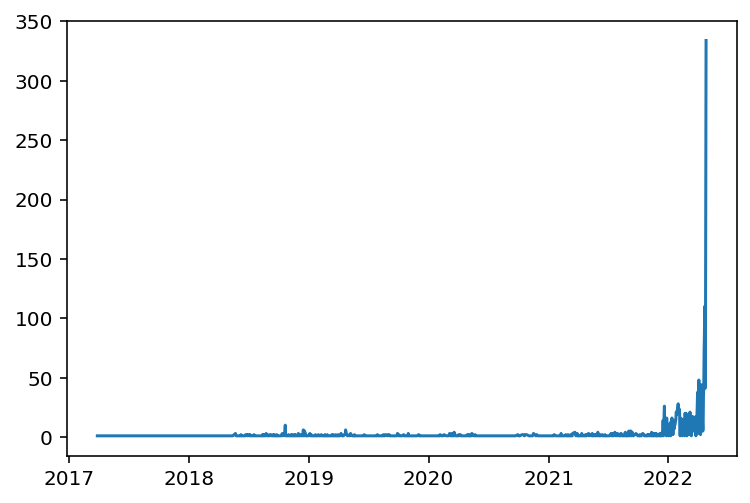

In [16]:
plt.plot(dates['index'], dates.date, linestyle = 'solid');

There is a certain amount of old news, they need to be removed

In [18]:
news_df = news_df[news_df.date > (pd.to_datetime("today") - np.timedelta64(1, 'M')).date()]
len(news_df)

1477

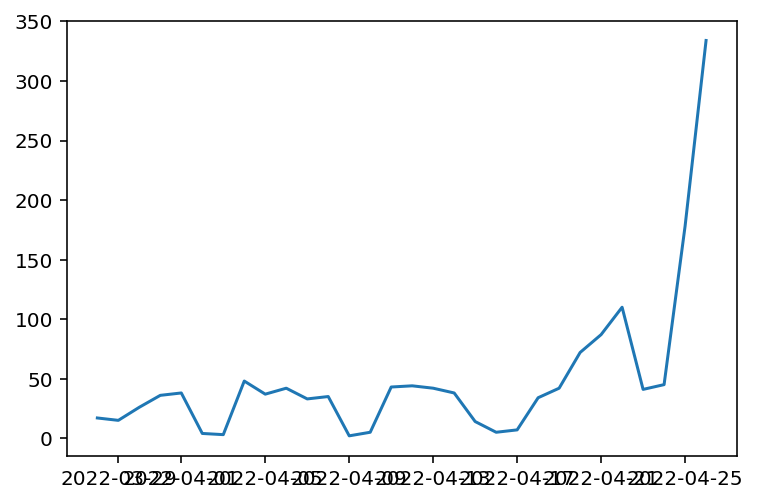

In [19]:
dates = pd.DataFrame(news_df.date.value_counts().reset_index()).sort_values('index')
plt.plot(dates['index'], dates.date, linestyle = 'solid');

In [20]:
latest_news = news_df[news_df.date > (pd.to_datetime("today") - np.timedelta64(2, 'D')).date()]
len(latest_news)

512

In [21]:
latest_news.source.value_counts()

https://u.today/                                      36
https://cointelegraph.com/feed                        30
https://decrypt.co/feed                               19
https://www.cryptonewsz.com/feed/                     19
https://www.investorideas.com/rss/feeds/iimain.xml    18
                                                      ..
https://coindoo.com/feed/                              1
https://about.crunchbase.com/blog/feed/                1
https://blog.coinbaazar.com/feed/                      1
https://www.bitrates.com/feed/rss                      1
https://blog.aragon.org/rss/                           1
Name: source, Length: 67, dtype: int64